In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as tf
import torchvision.datasets as dsets
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torch
torch.cuda.empty_cache()
CUDA=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

cuda
Version 1.7.0+cu101
CUDA enabled: True


# Data Setup

In [ ]:
!unzip celeb.zip
# use a smaller version of celeba dataset, contains 2000 images

In [ ]:
# sorted(glob.glob('celeb/' + "*.jpg"))
image_sample = sorted(glob.glob('celeb/' + "*.jpg"))[0]
image_sample=Image.open(image_sample)
a=tf.ToTensor()
b=a(image_sample)
b.shape

torch.Size([3, 176, 176])

In [ ]:
size = 256
scale = 4

In [ ]:
from torch.utils.data import Dataset, IterableDataset,DataLoader

class MyDataPreprocess (Dataset):
  def __init__(self,data_root,size,f):     #width = height = size; size: ground truth hr size 
    self.data_file = sorted(glob.glob(data_root + "*.jpg"))    
    #for vgg pretraining model
    # divide our dataset into 2 parts, low-resolution, high-resolution(lr,hr)
    self.transform_low = tf.Compose(
        [
        # transforms on PIL image 
        tf.CenterCrop((144,144)),
        tf.Resize(size=(size//f,size//f),interpolation=Image.BICUBIC),
        # transforms to tensor format
        tf.ToTensor(),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
    self.transform_high = tf.Compose([
        tf.CenterCrop((144,144)),
        tf.Resize(size=(size,size),interpolation=Image.BICUBIC),
        tf.ToTensor(),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    )
    
    
  def __getitem__(self, idx):
      index = idx%len(self.data_file)
      image = Image.open(self.data_file[index]) 
      sample = {'lr': self.transform_low(image), 'hr': self.transform_high(image)}
      return sample

  def __len__(self):
      return len(self.data_file)



In [ ]:
data_loader= DataLoader(MyDataPreprocess('celeb/',size = size, f= scale),
                   batch_size = 8,
                   shuffle= True)

In [ ]:
hr = data_loader.__iter__().next()['lr']
torch.max(hr)
# min = -2.1179
# max = 2.64

tensor(2.6400)

In [ ]:
print("low resolution image shape: ", data_loader.__iter__().next()['lr'].shape )
print("high resolution image shape: ", data_loader.__iter__().next()['hr'].shape )

low resolution image shape:  torch.Size([8, 3, 64, 64])
high resolution image shape:  torch.Size([8, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

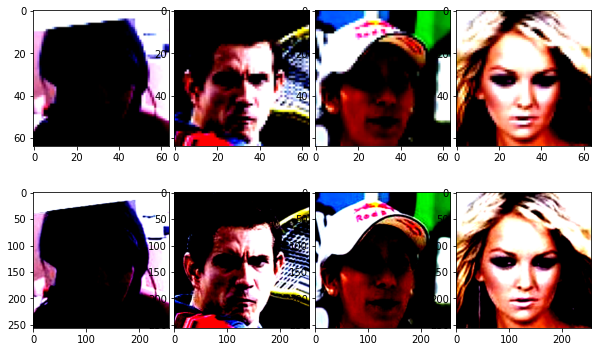

In [ ]:
img = data_loader.__iter__().next()
# img = nn.functional.interpolate(img, scale_factor=1,mode='bicubic')
img_lr = img['lr']
img_hr = img['hr']
plt.figure()
f, axarr = plt.subplots(2,4,figsize=(10,10)) 

for i in range(4):
  axarr[0][i].imshow(img_lr[i].permute(1,2,0))
  axarr[1][i].imshow(img_hr[i].permute(1,2,0))
  
plt.subplots_adjust(top = 0.5, bottom=0.001, hspace=0.03, wspace=0.04)

# plt.imshow(img_hr[0].permute(1,2,0))

# Generator Network

In [ ]:
import math
import torch
import torch.nn.functional as F
from torch import nn
import torchvision.models as models
# The architecture is based on the 
# "Photo-realistic single image super-resolution using a generative adversarial network"
# https://arxiv.org/abs/1609.04802

class ResidualBlock(nn.Module):
  def __init__(self,channels):
    super(ResidualBlock,self).__init__()
    self.ResidualModel = nn.Sequential(
        nn.Conv2d(channels, 64, 3, 1, 1),
        nn.BatchNorm2d(64,momentum=0.8),
        nn.PReLU(),
        nn.Conv2d(channels, 64, 3, 1, 1),
        nn.BatchNorm2d(64,momentum=0.8)
    )
  def forward(self, x):
    return x + self.ResidualModel(x)


In [ ]:
class UpSampleBlock(nn.Module):
  def __init__(self,channels, upscal_factor):
    super(UpSampleBlock,self).__init__()
    self.upscal_factor=upscal_factor
    self.UpSampleModel = nn.Sequential(
        nn.Conv2d(channels,256,3,1,padding=1),       # channel:64->256  w,h unchanged
        nn.PixelShuffle(2),    #channel: 256->64,   w,h -> 2*w, 2*h
        nn.PReLU()     
    )
  def forward(self,x):
    num_upsample = int(math.log(self.upscal_factor,2))
    for i in range(num_upsample):
      x=self.UpSampleModel(x)
    return x


In [ ]:
class GeneratorNetwork(nn.Module):
  def __init__(self,in_channel=3,upscal_factor=4):
    super(GeneratorNetwork,self).__init__()
    self.conv_preresnet = nn.Sequential(
        nn.Conv2d(in_channel,64,9,1,padding=4),  # padding = (9-1)/2=4
        nn.PReLU()
    )
    res_block = [ResidualBlock(64) for _ in range(5)]
    self.resnet = nn.Sequential(
        *res_block
    )
    self.conv_postresnet = nn.Sequential(
        nn.Conv2d(64,64,3,1,padding=1),
        nn.BatchNorm2d(64,momentum=0.8),
    )
    self.upsample_net= UpSampleBlock(64,upscal_factor)
    self.conv_last = nn.Conv2d(64,3,9,1,padding = 4)
    self.tanh = nn.Tanh()
  
  def forward(self,x):
    s1=self.conv_preresnet(x)
    s2=self.resnet(s1)
    s3=self.conv_postresnet(s2)
    s4=torch.add(s3,s1)   #skip connection
    s5=self.upsample_net(s4)
    s6=self.conv_last(s5)
    s7=self.tanh(s6)
    return 2.38*s7 + 0.26

# Discriminator Network

In [ ]:
class DiscriminatorNetwork(nn.Module):
  def __init__(self,in_channel=3, in_size=256):
    super(DiscriminatorNetwork,self).__init__()
    size_dense = in_size//(2**4)
    self.size_dense=size_dense
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channel, 64, 3, 1, padding = 1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,64,3,2,padding=1),   #w,h->0.5w,0.5h
        nn.BatchNorm2d(64,momentum=0.8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,128,3,1,padding=1),
        nn.BatchNorm2d(128,momentum=0.8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,128,3,2,padding=1),   #w,h->0.5w,0.5h
        nn.BatchNorm2d(128,momentum=0.8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,256,3,1,padding=1),
        nn.BatchNorm2d(256,momentum=0.8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,256,3,2,padding=1),   #w,h->0.5w,0.5h
        nn.BatchNorm2d(256,momentum=0.8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,512,3,1,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512,512,3,2,padding=1),   #w,h->0.5w,0.5h
        nn.BatchNorm2d(512,momentum=0.8),
        nn.LeakyReLU(0.2),
    )
    self.flatten= nn.Flatten()
    self.linear = nn.Sequential(
        nn.Linear(512*size_dense*size_dense,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,1),
    )

  def forward(self,x):
    s1=self.disc_model(x)
    s2=self.flatten(s1)
    s3=self.linear(s2)
    return s3


# Loss

Use VGG based perceptual loss function 

loss = content_loss  + 0.001*adversarial

In [ ]:
dtype = torch.cuda.FloatTensor

In [ ]:
import torchvision.models as models

# for vgg content loss, use L1 loss function to compute the loss, 
vgg19 = models.vgg19(pretrained=True)
FeatureExtractor = nn.Sequential(*list(vgg19.features.children())[:19])
FeatureExtractor.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# FeatureExtractor(img_lr)

In [ ]:
# Adversarial loss, use least square loss function
def my_bce_loss(input, target):
    loss = torch.max(input,torch.tensor([0]).to(device = 'cuda')) - \
    input* target+ torch.log(1+torch.exp(-torch.abs(input)))
    return loss.mean()

def my_discriminator_loss(scores_real, scores_fake):
    loss=0.5*torch.square(scores_real-1)+0.5*torch.square(scores_fake)
    loss=torch.mean(loss)
    return loss

def my_generator_loss(scores_fake):
    loss = 0.5*torch.square(scores_fake-1)
    loss=torch.mean(loss)
    return loss

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

# Optimizing the loss

In [ ]:
import torch.optim as optim

def my_get_optimizer(model):

    optimizer=optim.Adam(model.parameters(),lr=1e-5,betas=(0.5,0.999))

    return optimizer

G =GeneratorNetwork(3,scale).type(dtype)
D=DiscriminatorNetwork(3,size).type(dtype)
opt_D = my_get_optimizer(D)
opt_G = my_get_optimizer(G)


# Training the SRGAN

In [ ]:
len(data_loader)

313

In [ ]:
# lr=data_loader.__iter__().next()['hr'].type(dtype)
# # G(lr)
# lr

In [ ]:
def train(epochs, data_loader, opt_D, opt_G, G, D, D_loss, G_loss, feature_extractor,mse_loss,l1_loss):
  count = 0
  total_batch = len(data_loader)
  for epoch in range(epochs):
    for batch_ind, img in enumerate(data_loader):
      lr = img["lr"].type(dtype)
      hr = img["hr"].type(dtype)

      # discriminator loss
      opt_D.zero_grad()
      logits_real = D(hr).type(dtype)
      hr_gen = G(lr).detach()
      logits_fake = D(hr_gen)
      d_loss = D_loss(logits_real,logits_fake)
      d_loss.backward()
      opt_D.step()

      # generator loss, which is perceptual loss
      opt_G.zero_grad()
      hr_gen=G(lr)
      logits_fake = D(hr_gen)
      g_loss=G_loss(logits_fake)
      # print(hr_gen)
      gen_feature = feature_extractor(hr_gen)  #fake hr image feature extracted by the VGG19 model
      real_feature = feature_extractor(hr)    #real hr image feature extracted by the VGG19 model
      # print(gen_feature)
      loss_content = l1_loss(gen_feature,real_feature)            # content loss
      # print(loss_content)
      Per_loss = loss_content + 0.001*g_loss
      Per_loss.backward()
      opt_G.step()

      if batch_ind % 100 == 0:
            sys.stdout.write(
                "[Epoch {:3d}]    [Batch {:8d}/{:8d}]    [D loss: {:10.7f}]    [G loss: {:10.7f}]\n".format(
                    epoch, batch_ind, total_batch, d_loss.item(), Per_loss.item()
            ))
      if batch_ind % 100==0:
            imgs_lr = nn.functional.interpolate(lr, scale_factor=4)
            imgs_bi = nn.functional.interpolate(lr, scale_factor=4,mode = 'bicubic')

            imgs_bi = make_grid(imgs_bi, nrow=1, normalize=True)
            hr_gen = make_grid(hr_gen, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(hr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr,imgs_bi,hr_gen, imgs_hr ), -1)
            save_image(img_grid, "img/%d.jpg" % count, normalize=False)
            count+=1

        

In [ ]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 16914055168
free     : 5390598144
used     : 11523457024


In [ ]:
hr_gen, hr , lr = train(50,data_loader, opt_D, opt_G, G, D, 
                   my_discriminator_loss, my_generator_loss, FeatureExtractor,mse_loss,l1_loss)

[Epoch   0]    [Batch        0/     313]    [D loss:  0.0103668]    [G loss:  0.8984968]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Epoch   0]    [Batch      100/     313]    [D loss:  0.0036115]    [G loss:  0.9217243]
[Epoch   0]    [Batch      200/     313]    [D loss:  0.0216109]    [G loss:  0.9164160]


KeyboardInterrupt: ignored

In [ ]:
rm -rf img

In [ ]:
# lr = nn.functional.interpolate(lr, scale_factor=4)

# hr_gen = make_grid(hr_gen, nrow=1, normalize=True)
# # imgs_lr = make_grid(lr, nrow=1, normalize=True)
# imgs_hr = make_grid(hr, nrow=1, normalize=True)

# print(hr_gen.shape)
# img_grid = torch.cat((imgs_hr, hr_gen), -1)
# save_image(img_grid, "imgs2/%d.jpg" % 2, normalize=False)

In [ ]:
# plt.figure(figsize = (20,5))
# plt.imshow(lr.cpu().detach()[3].permute(1,2,0).numpy())

In [ ]:
del FeatureExtractor
del mse_loss
del my_generator_loss
del my_discriminator_loss
del opt_D
del opt_G
del G
del D
torch.cuda.empty_cache()